In [9]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, 
    BatchNormalization, Input, Attention, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.16.2
GPU available: True


## Configuration

In [11]:
# ===== CONFIGURATION =====
# Change these to train different models
COIN_NAME = "ethereum"  # bitcoin, ethereum, solana, cardano, binancecoin
HORIZON = "1h"         # 1h or 24h

# Paths
BASE_DIR = "/Users/ayushgupta/Desktop/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_November_Batch-5_2025"
DATA_DIR = f"{BASE_DIR}/Milestone_1/data"
SEQ_PATH = f"{DATA_DIR}/sequences/{COIN_NAME}/{HORIZON}/"
SCALED_PATH = f"{DATA_DIR}/scaled/{COIN_NAME}/"
MODEL_SAVE_PATH = f"{BASE_DIR}/Milestone_2/models/{COIN_NAME}/{HORIZON}/"

os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(SCALED_PATH, exist_ok=True)

# Model hyperparameters
LSTM_UNITS_1 = 128
LSTM_UNITS_2 = 64
DENSE_UNITS = 32
DROPOUT_RATE = 0.3
L2_REG = 0.001
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 15

print(f"Training {COIN_NAME} - {HORIZON} model")
print(f"Sequences path: {SEQ_PATH}")

Training ethereum - 1h model
Sequences path: /Users/ayushgupta/Desktop/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_November_Batch-5_2025/Milestone_1/data/sequences/ethereum/1h/


In [12]:
# ===== SPECIAL SETTINGS FOR BITCOIN =====
# Bitcoin needs different hyperparameters due to large price range ($15k → $126k)

if COIN_NAME == "bitcoin":
    print("⚠️ Using SPECIAL Bitcoin settings...")
    LSTM_UNITS_1 = 256      # More capacity (was 128)
    LSTM_UNITS_2 = 128      # More capacity (was 64)
    DENSE_UNITS = 64        # More capacity (was 32)
    DROPOUT_RATE = 0.15     # Less dropout (was 0.3)
    L2_REG = 0.0001         # Much less regularization (was 0.001)
    LEARNING_RATE = 0.0005  # Lower learning rate (was 0.001)
    BATCH_SIZE = 64         # Larger batch (was 32)
    EPOCHS = 150            # More epochs (was 100)
    PATIENCE = 25           # More patience (was 15)
    print(f"  LSTM: {LSTM_UNITS_1}/{LSTM_UNITS_2}, Dense: {DENSE_UNITS}")
    print(f"  Dropout: {DROPOUT_RATE}, L2: {L2_REG}, LR: {LEARNING_RATE}")
else:
    print(f"Using standard settings for {COIN_NAME}")

Using standard settings for ethereum


## Load Data

In [13]:
# Load sequences
X_train = np.load(SEQ_PATH + "X_train.npy")
y_train = np.load(SEQ_PATH + "y_train.npy")
X_val = np.load(SEQ_PATH + "X_val.npy")
y_val = np.load(SEQ_PATH + "y_val.npy")
X_test = np.load(SEQ_PATH + "X_test.npy")
y_test = np.load(SEQ_PATH + "y_test.npy")

print("Data shapes:")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape} | y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape} | y_test:  {y_test.shape}")
print(f"\nSequence length: {X_train.shape[1]}")
print(f"Number of features: {X_train.shape[2]}")

Data shapes:
  X_train: (30631, 48, 11) | y_train: (30631,)
  X_val:   (6525, 48, 11) | y_val:   (6525,)
  X_test:  (6527, 48, 11) | y_test:  (6527,)

Sequence length: 48
Number of features: 11


## Load Scalers

Load the scalers created by Split.ipynb (already fitted on full data range).

In [14]:
# Load scalers created by Split.ipynb (fitted on full data range)
feature_scaler = joblib.load(f"{SCALED_PATH}/feature_scaler.pkl")
price_scaler = joblib.load(f"{SCALED_PATH}/price_scaler.pkl")

print(f"Scalers loaded from {SCALED_PATH}")
print(f"Price scaler range: ${price_scaler.data_min_[0]:.2f} to ${price_scaler.data_max_[0]:.2f}")

Scalers loaded from /Users/ayushgupta/Desktop/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_November_Batch-5_2025/Milestone_1/data/scaled/ethereum/
Price scaler range: $466.49 to $4935.00


## Build Improved LSTM Model

In [15]:
def build_lstm_v2(seq_len, n_features):
    """
    Improved LSTM architecture with:
    - Bidirectional LSTM layers
    - Batch normalization for training stability
    - L2 regularization to prevent overfitting
    - Proper dropout placement
    """
    model = Sequential([
        # First Bidirectional LSTM layer
        Bidirectional(
            LSTM(LSTM_UNITS_1, return_sequences=True, 
                 kernel_regularizer=l2(L2_REG)),
            input_shape=(seq_len, n_features)
        ),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        # Second Bidirectional LSTM layer
        Bidirectional(
            LSTM(LSTM_UNITS_2, return_sequences=False,
                 kernel_regularizer=l2(L2_REG))
        ),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        # Dense layers
        Dense(DENSE_UNITS, activation='relu', kernel_regularizer=l2(L2_REG)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE / 2),
        
        Dense(16, activation='relu'),
        Dense(1)  # Output: predicted scaled price
    ])
    
    return model

# Build model
seq_len = X_train.shape[1]
n_features = X_train.shape[2]

model = build_lstm_v2(seq_len, n_features)

# Compile with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 48, 256)        │       143,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,049 (1.20 MB)

 Trainable params: 313,217 (1.19 MB)

 Non-trainable params: 832 (3.25 KB)

## Define Callbacks

In [16]:
# Callbacks for training
callbacks = [
    # Save best model
    ModelCheckpoint(
        f"{MODEL_SAVE_PATH}/best_lstm_{COIN_NAME}_{HORIZON}.keras",
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    
    # Early stopping with patience
    EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("Callbacks configured:")
print("  - ModelCheckpoint (save best)")
print("  - EarlyStopping (patience=15)")
print("  - ReduceLROnPlateau (factor=0.5)")

Callbacks configured:
  - ModelCheckpoint (save best)
  - EarlyStopping (patience=15)
  - ReduceLROnPlateau (factor=0.5)


## Train Model

In [17]:
print(f"\n{'='*50}")
print(f"Training {COIN_NAME} - {HORIZON} LSTM v2 Model")
print(f"{'='*50}\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print(f"\nTraining completed!")
print(f"Best validation loss: {min(history.history['val_loss']):.6f}")
print(f"Epochs trained: {len(history.history['loss'])}")


Training ethereum - 1h LSTM v2 Model

Epoch 1/100
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.8326 - mae: 0.3299
Epoch 1: val_loss improved from None to 0.20989, saving model to /Users/ayushgupta/Desktop/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_November_Batch-5_2025/Milestone_2/models/ethereum/1h//best_lstm_ethereum_1h.keras
958/958 ━━━━━━━━━━━━━━━━━━━━ 112s 114ms/step - loss: 0.4934 - mae: 0.1514 - val_loss: 0.2099 - val_mae: 0.0229 - learning_rate: 0.0010
Epoch 2/100
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1690 - mae: 0.0554
Epoch 2: val_loss improved from 0.20989 to 0.09784, saving model to /Users/ayushgupta/Desktop/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_November_Batch-5_2025/Milestone_2/models/ethereum/1h//best_lstm_ethereum_1h.keras
958/958 ━━━━━━━━━━━━━━━━━━━━ 109s 114ms/step - loss: 0.1361 - mae: 0.0558 - val_loss: 0.0978 - val_mae: 0.0936 - learning_rate: 0.0010
Epoch 3/100
958/958 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

## Training Visualization

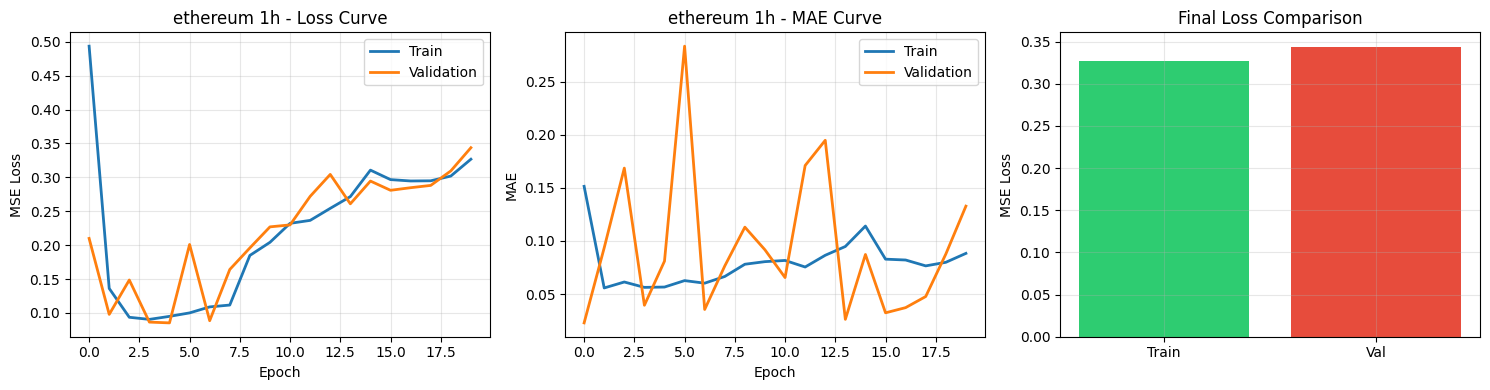

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curve
axes[0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0].set_title(f'{COIN_NAME} {HORIZON} - Loss Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE curve
axes[1].plot(history.history['mae'], label='Train', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation', linewidth=2)
axes[1].set_title(f'{COIN_NAME} {HORIZON} - MAE Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate (if available)
if 'lr' in history.history:
    axes[2].plot(history.history['lr'], linewidth=2, color='green')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_yscale('log')
else:
    # Show loss comparison
    axes[2].bar(['Train', 'Val'], 
                [history.history['loss'][-1], history.history['val_loss'][-1]],
                color=['#2ecc71', '#e74c3c'])
    axes[2].set_title('Final Loss Comparison')
    axes[2].set_ylabel('MSE Loss')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{MODEL_SAVE_PATH}/training_curves_{COIN_NAME}_{HORIZON}.png", dpi=150)
plt.show()

## Model Evaluation

In [19]:
def evaluate_model(y_true, y_pred, label="Model"):
    """Calculate and print comprehensive metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{label} Metrics:")
    print(f"  MAE:  {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2}

# Get predictions on test set
y_pred = model.predict(X_test, verbose=0).flatten()

print(f"{'='*50}")
print(f"TEST SET EVALUATION - {COIN_NAME} {HORIZON}")
print(f"{'='*50}")

# Evaluate on scaled values
scaled_metrics = evaluate_model(y_test, y_pred, "Scaled Predictions")

# Inverse transform to get real prices
y_test_real = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real = price_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

real_metrics = evaluate_model(y_test_real, y_pred_real, "Real Price Predictions")

print(f"\n{'='*50}")
print(f"Price prediction range: ${y_pred_real.min():.2f} to ${y_pred_real.max():.2f}")
print(f"Actual price range:     ${y_test_real.min():.2f} to ${y_test_real.max():.2f}")

TEST SET EVALUATION - ethereum 1h

Scaled Predictions Metrics:
  MAE:  0.088131
  RMSE: 0.102051
  MAPE: 14.04%
  R²:   0.7895

Real Price Predictions Metrics:
  MAE:  393.815338
  RMSE: 456.017013
  MAPE: 11.80%
  R²:   0.7895

Price prediction range: $1379.76 to $3893.32
Actual price range:     $1418.80 to $4935.00


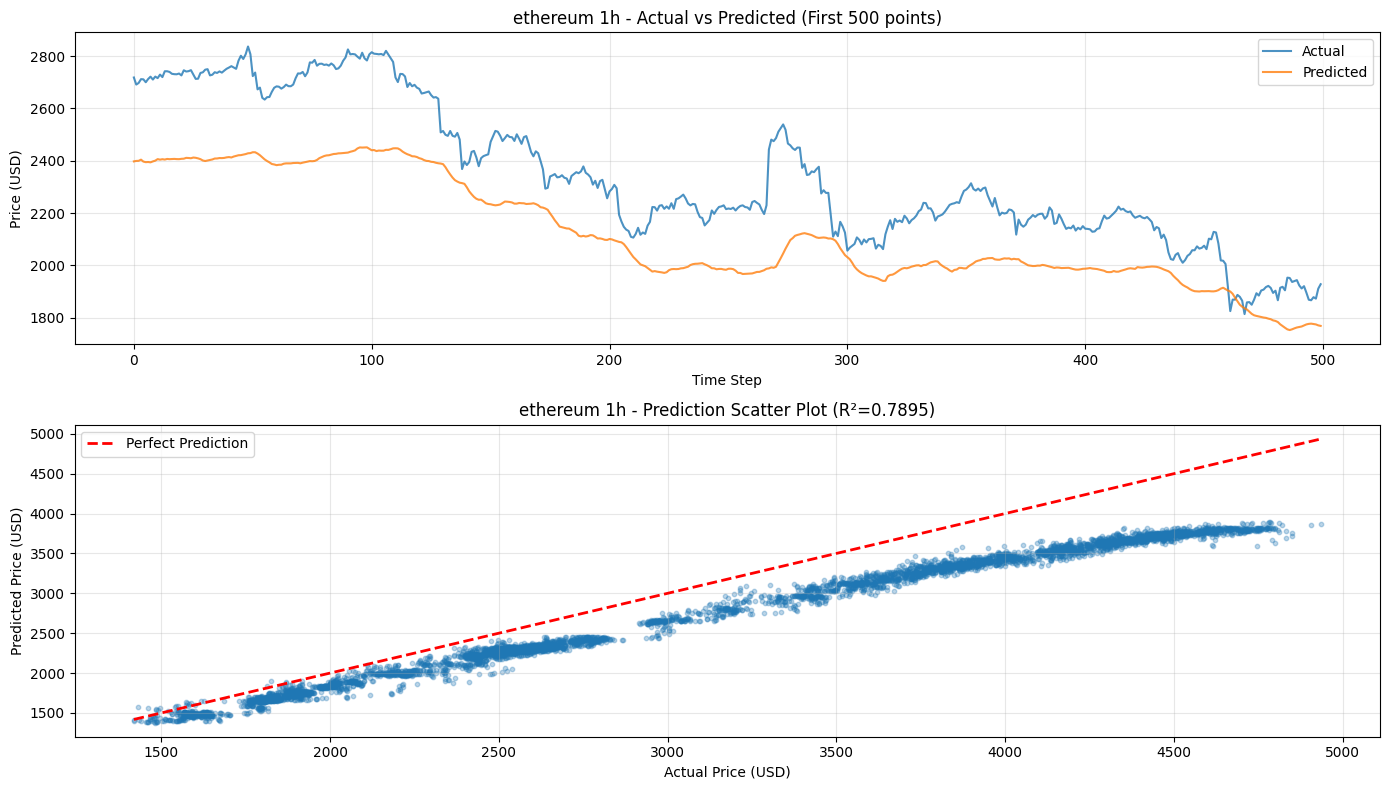

In [20]:
# Prediction visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full test set (first 500 points)
n_points = min(500, len(y_test_real))
axes[0].plot(y_test_real[:n_points], label='Actual', linewidth=1.5, alpha=0.8)
axes[0].plot(y_pred_real[:n_points], label='Predicted', linewidth=1.5, alpha=0.8)
axes[0].set_title(f'{COIN_NAME} {HORIZON} - Actual vs Predicted (First {n_points} points)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(y_test_real, y_pred_real, alpha=0.3, s=10)
axes[1].plot([y_test_real.min(), y_test_real.max()], 
             [y_test_real.min(), y_test_real.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title(f'{COIN_NAME} {HORIZON} - Prediction Scatter Plot (R²={real_metrics["r2"]:.4f})')
axes[1].set_xlabel('Actual Price (USD)')
axes[1].set_ylabel('Predicted Price (USD)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{MODEL_SAVE_PATH}/predictions_{COIN_NAME}_{HORIZON}.png", dpi=150)
plt.show()

## Save Final Model

In [21]:
# Save the final model
final_path = f"{MODEL_SAVE_PATH}/final_lstm_{COIN_NAME}_{HORIZON}.keras"
model.save(final_path)

print(f"\n{'='*50}")
print("MODEL SAVED SUCCESSFULLY")
print(f"{'='*50}")
print(f"\nModel path: {final_path}")
print(f"Scaler path: {SCALED_PATH}")
print(f"\nFinal Metrics Summary:")
print(f"  - MAPE: {real_metrics['mape']:.2f}%")
print(f"  - R²:   {real_metrics['r2']:.4f}")
print(f"  - MAE:  ${real_metrics['mae']:.2f}")


MODEL SAVED SUCCESSFULLY

Model path: /Users/ayushgupta/Desktop/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_November_Batch-5_2025/Milestone_2/models/ethereum/1h//final_lstm_ethereum_1h.keras
Scaler path: /Users/ayushgupta/Desktop/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_November_Batch-5_2025/Milestone_1/data/scaled/ethereum/

Final Metrics Summary:
  - MAPE: 11.80%
  - R²:   0.7895
  - MAE:  $393.82
